In [14]:
import csv
import numpy as np
import os
import pandas as pd

%matplotlib inline

# Families and the titanic
## Questions to investigate:

    How did family size effect the survival rate? 
    How did women and orphans fare?
    Were upper class families more likely to survive?
    

## Loading the Data

In [2]:
cwd = os.getcwd()
data_set = os.path.join(cwd,"titanic.csv")
df = pd.read_csv(data_set)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


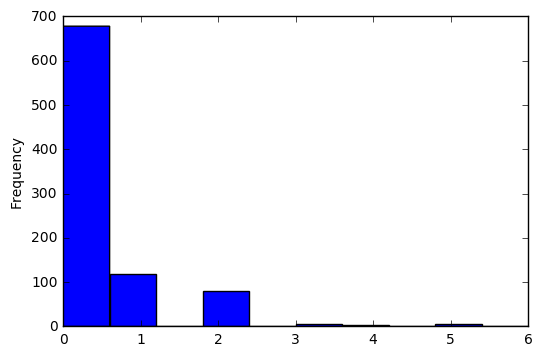

In [31]:
#Create Family size feature
df['family_size']= df['SibSp'] + df['Parch']
%matplotlib inline
# df['family_size'].plot(kind = "hist")
# df['SibSp'].plot(kind = "hist")
df['Parch'].plot(kind = "hist")



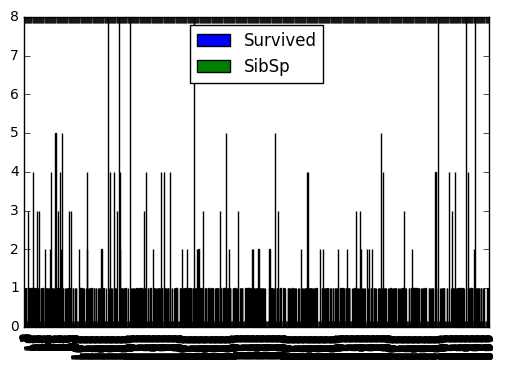

In [34]:
df['Survived', 'SibSp'].plot(kind = "bar")

## Create Gender Feature

In [6]:
sex_dummies = pd.get_dummies(df['Sex'])
pd.concat([df,sex_dummies], axis=1)
sex_dummies


,female,male
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,1.0,0.0
9,1.0,0.0
